In [1]:
!git clone https://github.com/pyimagesearch/TripoSR.git
import sys
sys.path.append('/content/TripoSR/tsr')
%cd TripoSR
!pip install -r requirements.txt -q

fatal: destination path 'TripoSR' already exists and is not an empty directory.
/kaggle/working/TripoSR
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install scikit-learn==1.3.1
!pip install matplotlib==3.8.0
!pip install onnxruntime

In [3]:
import torch
import os
import time
from PIL import Image
import numpy as np
from IPython.display import Video
from tsr.system import TSR
from tsr.utils import remove_background, resize_foreground, save_video
import pymeshlab as pymesh
import rembg

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [55]:
original_image = Image.open("/kaggle/input/twod-to-threed-dataset/product.jpg")
original_image = original_image.convert("RGBA")
original_image = original_image.resize((512,512))

In [56]:
print(original_image.mode)

RGBA


In [58]:
image_paths = "/kaggle/input/twod-to-threed-dataset/product.jpg"
device = "cuda:0"
pretrained_model_name_or_path = "stabilityai/TripoSR"
chunk_size = 8192
no_remove_bg = True
foreground_ratio = 0.85
output_dir = "output/"
model_save_format = "obj"
render = True
output_dir = output_dir.strip()
os.makedirs(output_dir, exist_ok=True)

In [59]:
model = TSR.from_pretrained(
	pretrained_model_name_or_path,
	config_name="config.yaml",
	weight_name="model.ckpt",
)
model.renderer.set_chunk_size(chunk_size)
model.to(device)

TSR(
  (image_tokenizer): DINOSingleImageTokenizer(
    (model): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTSdpaAttention(
              (attention): ViTSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
     

In [60]:
images = []
rembg_session = rembg.new_session()
image = remove_background(original_image, rembg_session)
image = resize_foreground(image, foreground_ratio)
# image = resize_foreground(original_image, 512)
if image.mode == "RGBA":
    image = np.array(image).astype(np.float32) / 255.0
    image = image[:, :, :3] * image[:, :, 3:4] + (1 - image[:, :, 3:4]) * 0.5
    image = Image.fromarray((image * 255.0).astype(np.uint8))
image_dir = os.path.join(output_dir, str(0))
os.makedirs(image_dir, exist_ok=True)
image.save(os.path.join(image_dir, "input.png"))
images.append(image)

In [61]:
for i, image in enumerate(images):
    print(f"Running image {i + 1}/{len(images)} ...")
    with torch.no_grad():
        scene_codes = model([image], device=device)
    
    if render:
        render_images = model.render(scene_codes, n_views=30, return_type="pil")
        for ri, render_image in enumerate(render_images[0]):
            render_image.save(os.path.join(output_dir, str(i), f"render_{ri:03d}.png"))
        save_video(
            render_images[0], os.path.join(output_dir, str(i), "render.mp4"), fps=30
        )
    
    meshes = model.extract_mesh(scene_codes, has_vertex_color=False)
    mesh_file = os.path.join(output_dir, str(i), f"mesh.{model_save_format}")
    meshes[0].export(mesh_file)

Running image 1/1 ...


In [62]:
obj_file = "/kaggle/working/TripoSR/output/0/mesh.obj"
ms = pymesh.MeshSet()
ms.load_new_mesh(obj_file)
stl_file = 'model.stl'
ms.save_current_mesh(stl_file)
# Convert to .stl format
stl_file = 'model.stl'
ms.save_current_mesh(stl_file)

In [63]:
Video('/kaggle/working/TripoSR/TripoSR/output/0/render.mp4', embed=True)

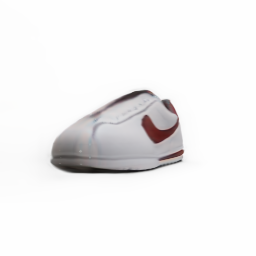

In [65]:
Image.open("/kaggle/working/TripoSR/output/0/render_025.png")